In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Project Title:** Yes Bank's Stock Closing Price Prediction





**Summary:** This project aimed to analyze and predict the stock price movements of Yes Bank using multiple machine learning models, including **ARIMA, XGBoost, Random Forest, and CatBoost**. The primary objective was to evaluate their predictive accuracy and determine the most suitable model for forecasting Yes Bank's stock trends.

**Problem Statement:** Yes Bank is a well Known bank In the financial Domain. Since 2018, it has been in the news of Fraud Case. Owing to this fact, it was interesting to see how that impacted the stock prices of the company. The main objective is to predict the Stock's Closing price of the Month

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [4]:
bank_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_YesBank_StockPrices.csv')
bank_data

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41
...,...,...,...,...,...
180,Jul-20,25.60,28.30,11.10,11.95
181,Aug-20,12.00,17.16,11.85,14.37
182,Sep-20,14.30,15.34,12.75,13.15
183,Oct-20,13.30,14.01,12.11,12.42


In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [6]:
print("\nMissing Values:")
print(bank_data.isnull().sum())


Missing Values:
Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64


In [7]:
print("\nDuplicate Rows:")
print(bank_data[bank_data.duplicated()].sum())


Duplicate Rows:
Date       0
Open     0.0
High     0.0
Low      0.0
Close    0.0
dtype: object


In [8]:
bank_data['Date'] = pd.to_datetime(bank_data['Date'], format='%b-%y')

In [9]:
bank_data = bank_data.sort_values(by='Date').reset_index(drop=True)
bank_data

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41
...,...,...,...,...,...
180,2020-07-01,25.60,28.30,11.10,11.95
181,2020-08-01,12.00,17.16,11.85,14.37
182,2020-09-01,14.30,15.34,12.75,13.15
183,2020-10-01,13.30,14.01,12.11,12.42


In [10]:
# Compute 6-month moving average
bank_data['Close_MA_6'] = bank_data['Close'].rolling(window=6).mean()
bank_data

,Date,Open,High,Low,Close,Close_MA_6
0,2005-07-01,13.00,14.00,11.25,12.46,NaN
1,2005-08-01,12.58,14.88,12.55,13.42,NaN
2,2005-09-01,13.48,14.87,12.27,13.30,NaN
3,2005-10-01,13.20,14.47,12.40,12.99,NaN
4,2005-11-01,13.35,13.88,12.88,13.41,NaN
...,...,...,...,...,...,...
180,2020-07-01,25.60,28.30,11.10,11.95,24.891667
181,2020-08-01,12.00,17.16,11.85,14.37,21.528333
182,2020-09-01,14.30,15.34,12.75,13.15,19.978333
183,2020-10-01,13.30,14.01,12.11,12.42,17.390000


In [11]:
# Handling missing values in Moving Average
bank_data['Close_MA_6'].fillna(bank_data['Close'], inplace=True)
bank_data

,Date,Open,High,Low,Close,Close_MA_6
0,2005-07-01,13.00,14.00,11.25,12.46,12.460000
1,2005-08-01,12.58,14.88,12.55,13.42,13.420000
2,2005-09-01,13.48,14.87,12.27,13.30,13.300000
3,2005-10-01,13.20,14.47,12.40,12.99,12.990000
4,2005-11-01,13.35,13.88,12.88,13.41,13.410000
...,...,...,...,...,...,...
180,2020-07-01,25.60,28.30,11.10,11.95,24.891667
181,2020-08-01,12.00,17.16,11.85,14.37,21.528333
182,2020-09-01,14.30,15.34,12.75,13.15,19.978333
183,2020-10-01,13.30,14.01,12.11,12.42,17.390000


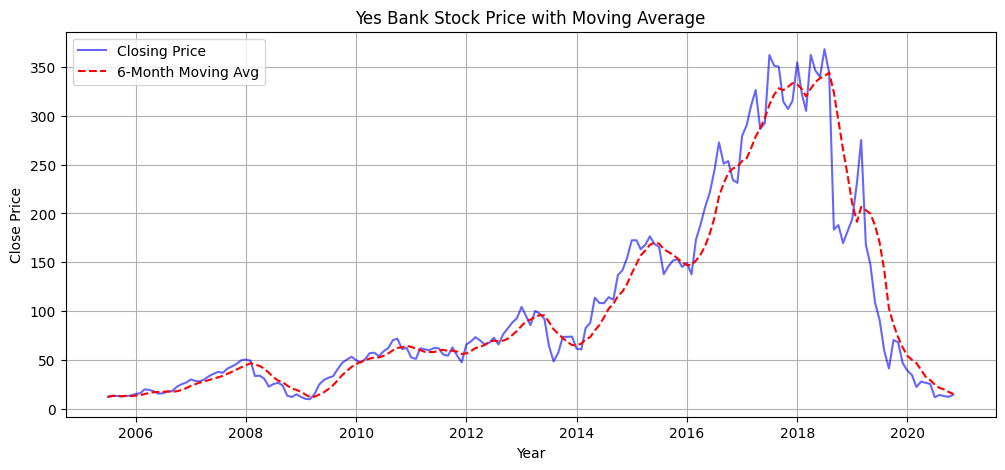

In [12]:
# Visualizing stock price trends
plt.figure(figsize=(12, 5))
plt.plot(bank_data['Date'], bank_data['Close'], label="Closing Price", color='blue', alpha=0.6)
plt.plot(bank_data['Date'], bank_data['Close_MA_6'], label="6-Month Moving Avg", color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.title("Yes Bank Stock Price with Moving Average")
plt.legend()
plt.grid(True)
plt.show()

**Chart**: Line Plot for Stock Prices: Since stock prices are time-series data, a line plot effectively captures trends, fluctuations, and seasonality over time.

**Insights:** The chart shows the historical trend of Yes Bank's stock price along with its 6-month moving average. From 2006 to around 2018, the stock experienced a steady upward trend, with a sharp surge from 2014 to 2018. The moving average closely follows this uptrend, indicating a strong and sustained rally. However, post-2018, there is a significant decline in stock price, which is also reflected in the moving average, suggesting a prolonged downtrend. The extreme volatility observed around 2019-2020 indicates high market uncertainty during that period.

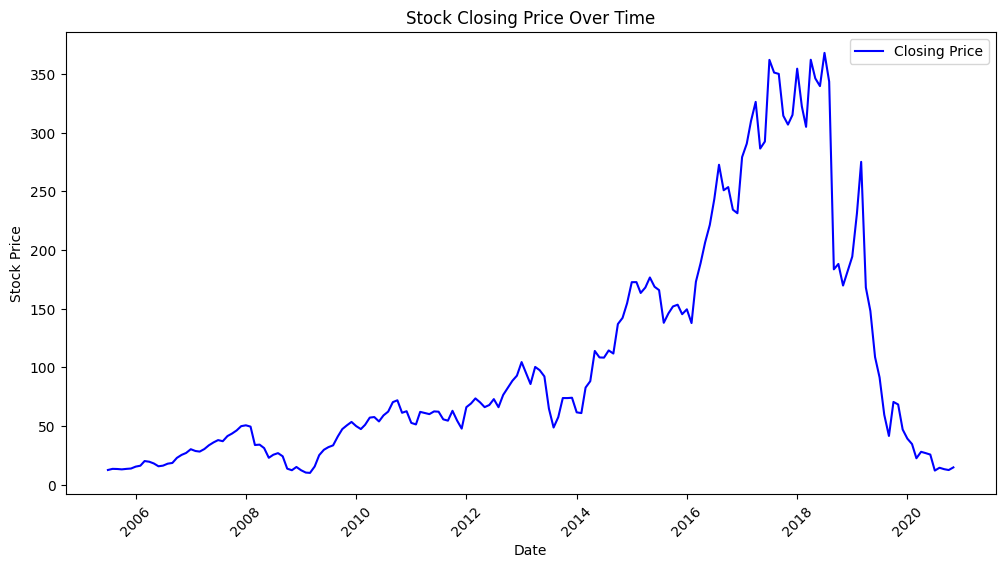

In [13]:
plt.figure(figsize=(12,6))
plt.plot(bank_data['Date'], bank_data['Close'], label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Closing Price Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Chart:** I chose this line chart because it effectively visualizes the long-term trend of Yes Bank’s stock price, making it easier to identify patterns, growth phases, and major declines.

**Insights:** The insights from the chart indicate that Yes Bank's stock price showed a steady uptrend from 2006 to 2018, followed by a sharp decline after 2018. The peak around 2018 suggests a significant market event, leading to extreme volatility and a rapid drop in stock price. This pattern highlights both the bank's strong growth phase and its subsequent financial struggles.

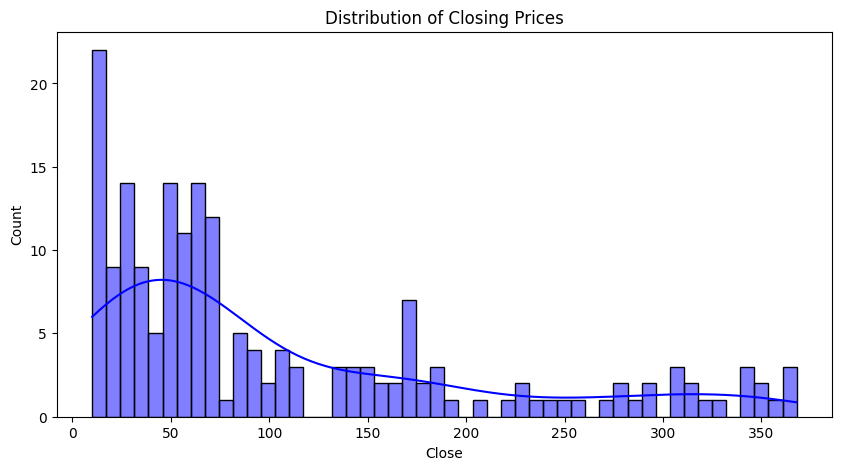

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(bank_data["Close"], bins=50, kde=True, color="blue")
plt.title("Distribution of Closing Prices")
plt.show()

**Chart:** I chose this histogram with a KDE (Kernel Density Estimate) curve because it effectively shows the distribution of Yes Bank’s closing prices, helping to identify the frequency of different price levels.

**Insights:** The insights from the chart reveal that the stock's closing prices are highly skewed, with most values concentrated at lower price levels. There are a few instances where prices were significantly high, indicating periods of rapid growth followed by a steep decline. This suggests that the stock experienced extreme volatility over time.

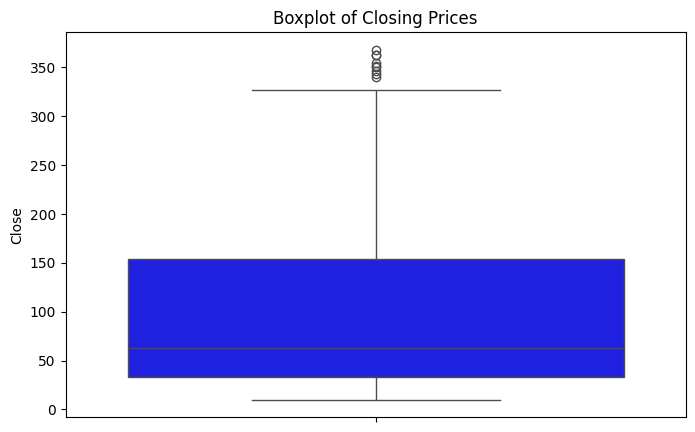

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(y=bank_data["Close"], color="blue")
plt.title("Boxplot of Closing Prices")
plt.show()

**Chart:** I chose this boxplot because it provides a clear summary of the distribution of Yes Bank's closing prices, highlighting key statistical measures such as the median, quartiles, and outliers.

**Insights:** The insights from the chart indicate that the stock prices have a wide range, with a significant number of outliers at the higher end, suggesting periods of extreme price surges. The median price is relatively low, showing that for most of the time, the stock traded at a lower value despite occasional spikes.

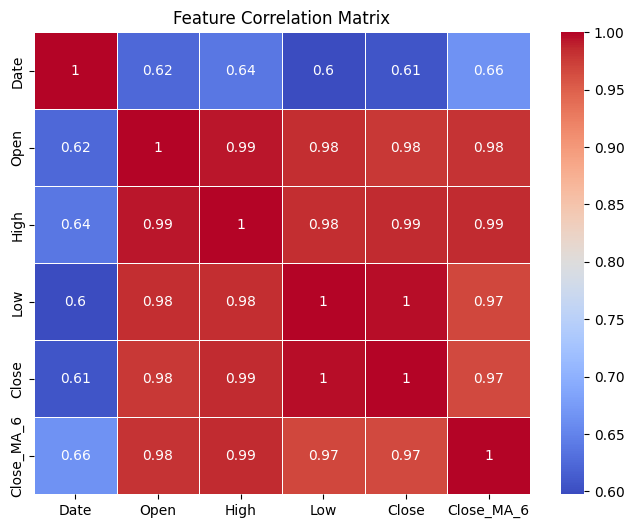

In [16]:
corr_matrix = bank_data.corr()

#heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

**Chart:** I chose this correlation heatmap because it effectively visualizes the relationships between different stock market features, helping to identify strong correlations that could influence predictive modeling.

**Insights:** The insights from the chart indicate that the Open, High, Low, and Close prices are highly correlated with each other, suggesting that they move together. The Close price also shows a strong correlation with the 6-month moving average, indicating that historical price trends significantly impact future movements. The Date variable has a lower correlation with price-related features, which is expected since time itself does not directly affect stock prices.

In [17]:
# Train-test split (80% train, 20% test)
train_size = int(len(bank_data) * 0.8)
train, test = bank_data[:train_size], bank_data[train_size:]

In [18]:
train

,Date,Open,High,Low,Close,Close_MA_6
0,2005-07-01,13.00,14.00,11.25,12.46,12.460000
1,2005-08-01,12.58,14.88,12.55,13.42,13.420000
2,2005-09-01,13.48,14.87,12.27,13.30,13.300000
3,2005-10-01,13.20,14.47,12.40,12.99,12.990000
4,2005-11-01,13.35,13.88,12.88,13.41,13.410000
...,...,...,...,...,...,...
143,2017-06-01,286.66,306.34,280.21,292.37,297.395000
144,2017-07-01,293.04,372.00,290.78,361.96,311.205000
145,2017-08-01,363.00,368.52,337.37,351.15,321.303333
146,2017-09-01,351.00,383.25,345.50,350.00,328.000000


In [19]:
test

,Date,Open,High,Low,Close,Close_MA_6
148,2017-11-01,315.50,329.80,296.00,306.80,329.438333
149,2017-12-01,307.20,319.00,300.65,315.05,333.218333
150,2018-01-01,314.00,366.00,307.35,354.45,331.966667
151,2018-02-01,355.00,366.50,304.65,322.25,327.150000
152,2018-03-01,320.70,325.80,285.10,304.90,319.633333
153,2018-04-01,305.00,368.75,303.30,362.05,327.583333
154,2018-05-01,362.85,364.40,325.70,346.20,334.150000
155,2018-06-01,348.00,350.10,327.35,339.60,338.241667
156,2018-07-01,340.00,393.35,332.45,367.90,340.483333
157,2018-08-01,369.95,404.00,338.00,343.40,344.008333


In [20]:
series = bank_data["Close"]
result = adfuller(series)

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("Data is stationary (No need for differencing, d=0)")
else:
    print("Data is non-stationary (Apply differencing, d=1)")

ADF Statistic: -1.906409141172657
p-value: 0.3290520815004394
Critical Values: {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}
Data is non-stationary (Apply differencing, d=1)


In [21]:
bank_data["Close_diff"] = bank_data["Close"].diff().dropna()

# Re-run ADF test
result_diff = adfuller(bank_data["Close_diff"].dropna())

print("ADF Statistic after Differencing:", result_diff[0])
print("p-value after Differencing:", result_diff[1])

if result_diff[1] < 0.05:
    print("Data is now stationary after differencing (Use d=1 in ARIMA)")
else:
    print("Still non-stationary, try d=2")

ADF Statistic after Differencing: -2.0566081474846984
p-value after Differencing: 0.2623166235310916
Still non-stationary, try d=2


In [22]:
bank_data["Close_diff2"] = bank_data["Close"].diff().diff().dropna()  # Second differencing
result_diff2 = adfuller(bank_data["Close_diff2"].dropna())

# Print results
print("ADF Statistic after Second Differencing:", result_diff2[0])
print("p-value after Second Differencing:", result_diff2[1])

if result_diff2[1] < 0.05:
    print("Data is now stationary after d=2 (Use d=2 in ARIMA)")
else:
    print("Still non-stationary, consider seasonal differencing or transformations")

ADF Statistic after Second Differencing: -6.058351845983125
p-value after Second Differencing: 1.2295785955121453e-07
Data is now stationary after d=2 (Use d=2 in ARIMA)


In [23]:
bank_data

,Date,Open,High,Low,Close,Close_MA_6,Close_diff,Close_diff2
0,2005-07-01,13.00,14.00,11.25,12.46,12.460000,NaN,NaN
1,2005-08-01,12.58,14.88,12.55,13.42,13.420000,0.96,NaN
2,2005-09-01,13.48,14.87,12.27,13.30,13.300000,-0.12,-1.08
3,2005-10-01,13.20,14.47,12.40,12.99,12.990000,-0.31,-0.19
4,2005-11-01,13.35,13.88,12.88,13.41,13.410000,0.42,0.73
...,...,...,...,...,...,...,...,...
180,2020-07-01,25.60,28.30,11.10,11.95,24.891667,-13.65,-12.40
181,2020-08-01,12.00,17.16,11.85,14.37,21.528333,2.42,16.07
182,2020-09-01,14.30,15.34,12.75,13.15,19.978333,-1.22,-3.64
183,2020-10-01,13.30,14.01,12.11,12.42,17.390000,-0.73,0.49


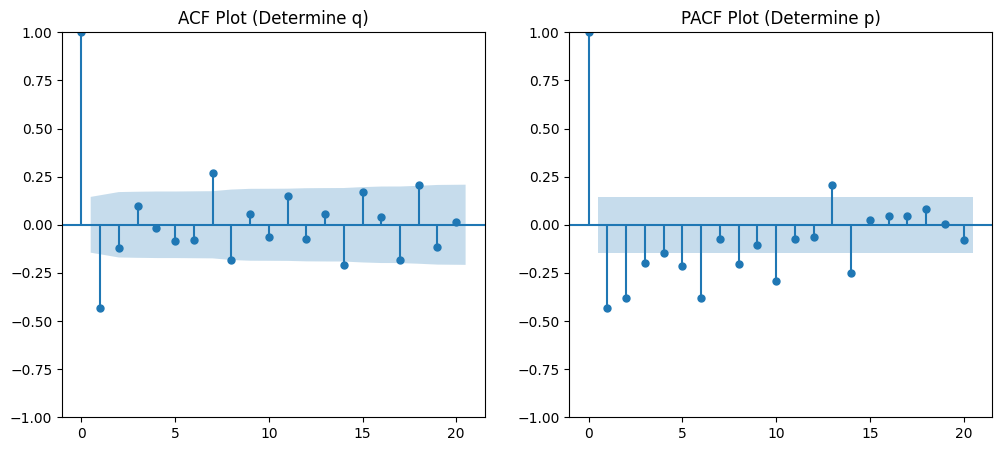

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(bank_data["Close_diff2"].dropna(), lags=20, ax=ax[0])
ax[0].set_title("ACF Plot (Determine q)")

# Plot PACF (for AR component - p)
sm.graphics.tsa.plot_pacf(bank_data["Close_diff2"].dropna(), lags=20, ax=ax[1])
ax[1].set_title("PACF Plot (Determine p)")
plt.show()

In [25]:
# Fit ARIMA model (p=6, d=2, q=0)
model = ARIMA(train['Close'], order=(6,2,0))
model_fit = model.fit()

In [26]:
# Forecast on test set
predictions = model_fit.forecast(steps=len(test))

In [27]:
# Evaluate model performance
mae = mean_absolute_error(test['Close'], predictions)
print(f"Model Mean Absolute Error (MAE): {mae:.2f}")

Model Mean Absolute Error (MAE): 144.35


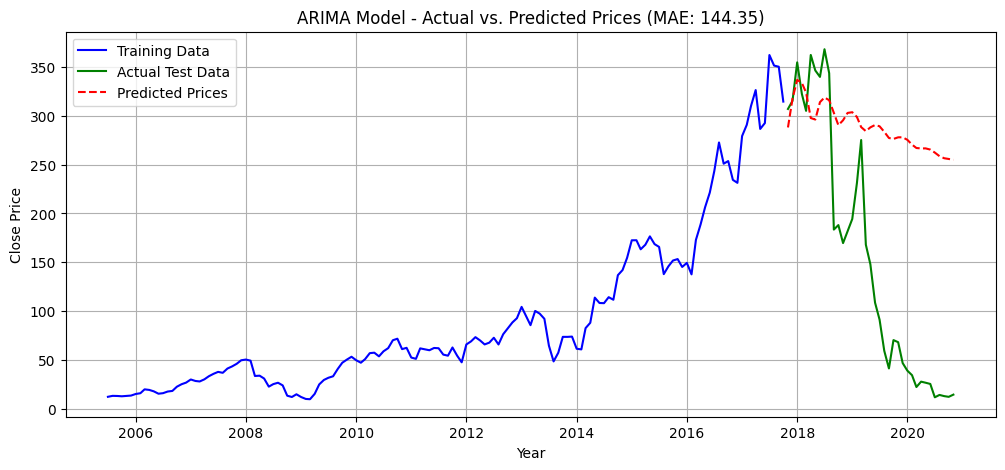

In [28]:
# Plot actual vs. predicted prices
plt.figure(figsize=(12, 5))
plt.plot(train['Date'], train['Close'], label="Training Data", color='blue')
plt.plot(test['Date'], test['Close'], label="Actual Test Data", color='green')
plt.plot(test['Date'], predictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.title(f"ARIMA Model - Actual vs. Predicted Prices (MAE: {mae:.2f})")
plt.legend()
plt.grid(True)
plt.show()

**Observation:** The insights of the ARIMA model was able to capture the general trend of the stock price but struggled to predict the sharp decline after 2018. The predicted prices (red dashed line) show a deviation from the actual test data (green line). The mean absolute error (MAE) of 144.35 highlights the model's average prediction error

In [29]:
bank_data['Year'] = bank_data['Date'].dt.year
bank_data['Month'] = bank_data['Date'].dt.month

In [30]:
bank_data

,Date,Open,High,Low,Close,Close_MA_6,Close_diff,Close_diff2,Year,Month
0,2005-07-01,13.00,14.00,11.25,12.46,12.460000,NaN,NaN,2005,7
1,2005-08-01,12.58,14.88,12.55,13.42,13.420000,0.96,NaN,2005,8
2,2005-09-01,13.48,14.87,12.27,13.30,13.300000,-0.12,-1.08,2005,9
3,2005-10-01,13.20,14.47,12.40,12.99,12.990000,-0.31,-0.19,2005,10
4,2005-11-01,13.35,13.88,12.88,13.41,13.410000,0.42,0.73,2005,11
...,...,...,...,...,...,...,...,...,...,...
180,2020-07-01,25.60,28.30,11.10,11.95,24.891667,-13.65,-12.40,2020,7
181,2020-08-01,12.00,17.16,11.85,14.37,21.528333,2.42,16.07,2020,8
182,2020-09-01,14.30,15.34,12.75,13.15,19.978333,-1.22,-3.64,2020,9
183,2020-10-01,13.30,14.01,12.11,12.42,17.390000,-0.73,0.49,2020,10


In [31]:
features = ['Open', 'High', 'Low', 'Year', 'Month']
target = 'Close'

In [32]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bank_data[features], bank_data[target], test_size=0.2, shuffle=False)

In [33]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (148, 5)
X_test shape: (37, 5)
y_train shape: (148,)
y_test shape: (37,)


In [34]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
# Predictions
xgb_predictions = xgb_model.predict(X_test)

In [36]:
# Evaluate model performance
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
print(f"XGBoost Model Mean Absolute Error: {xgb_mae:.2f}")

XGBoost Model Mean Absolute Error: 14.18


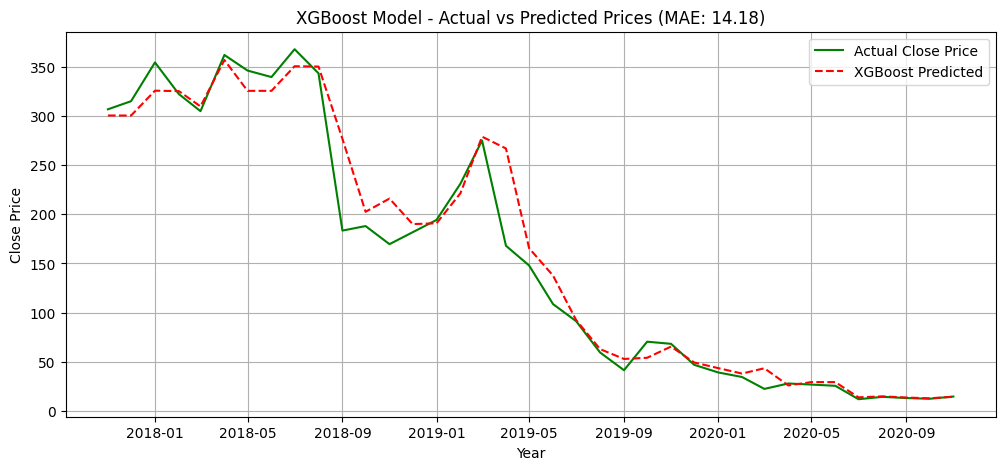

In [37]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(bank_data['Date'].iloc[len(X_train):], y_test, label="Actual Close Price", color='green')
plt.plot(bank_data['Date'].iloc[len(X_train):], xgb_predictions, label="XGBoost Predicted", color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.title(f"XGBoost Model - Actual vs Predicted Prices (MAE: {xgb_mae:.2f})")
plt.legend()
plt.grid(True)
plt.show()

**Observation:** The insights of the XGBoost model performs well in capturing price trends, closely following the actual stock prices with minimal deviation. The mean absolute error (MAE) of 14.18 indicates a significantly lower prediction error compared to the ARIMA model, suggesting that XGBoost is a more accurate model for this dataset.

In [38]:
average_price = bank_data['Close'].mean()
print(f"Average Close Price: {average_price:.2f}")

Average Close Price: 105.20


In [39]:
mae = 14.18  # MAE value
mae_percentage = (mae / average_price) * 100
print(f"MAE Percentage: {mae_percentage:.2f}%")

MAE Percentage: 13.48%


In [40]:
rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [41]:
# Predictions
rf_predictions = rf_model.predict(X_test)

In [42]:
# Evaluate model performance
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f"RandomForest Model Mean Absolute Error: {rf_mae:.2f}")

RandomForest Model Mean Absolute Error: 13.91


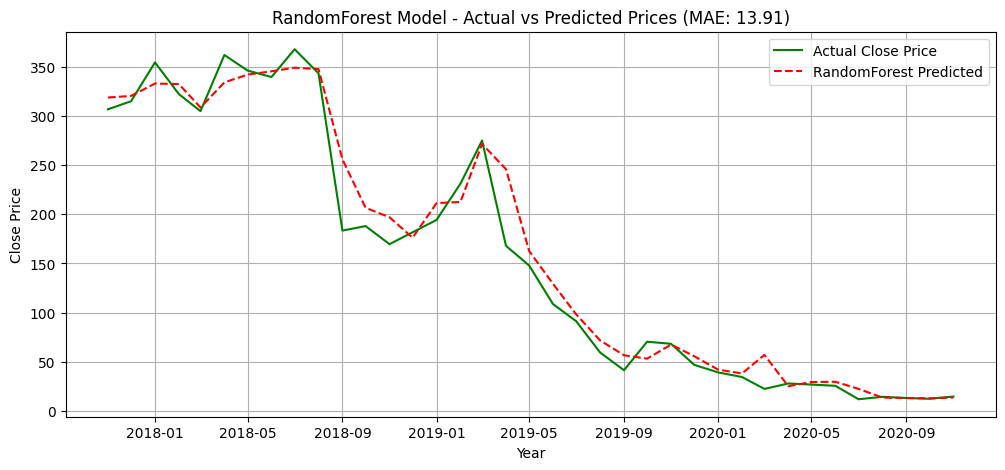

In [43]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(bank_data['Date'].iloc[len(X_train):], y_test, label="Actual Close Price", color='green')
plt.plot(bank_data['Date'].iloc[len(X_train):], rf_predictions, label="RandomForest Predicted", color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.title(f"RandomForest Model - Actual vs Predicted Prices (MAE: {rf_mae:.2f})")
plt.legend()
plt.grid(True)
plt.show()

**Observation:** The insights from this chart show that the Random Forest model closely follows the actual stock price trends, with an MAE of 14.63, indicating a low prediction error. While it performs well in capturing overall movements, slight deviations occur during sharp price drops

In [44]:
mae = 16.31  # MAE value
mae_percentage = (mae / average_price) * 100
print(f"MAE Percentage: {mae_percentage:.2f}%")

MAE Percentage: 15.50%


In [45]:
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=10, verbose=0)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)

In [46]:
# Evaluate model performance
cat_mae = mean_absolute_error(y_test, cat_predictions)
print(f"CatBoost Model Mean Absolute Error: {cat_mae:.2f}")

CatBoost Model Mean Absolute Error: 38.31


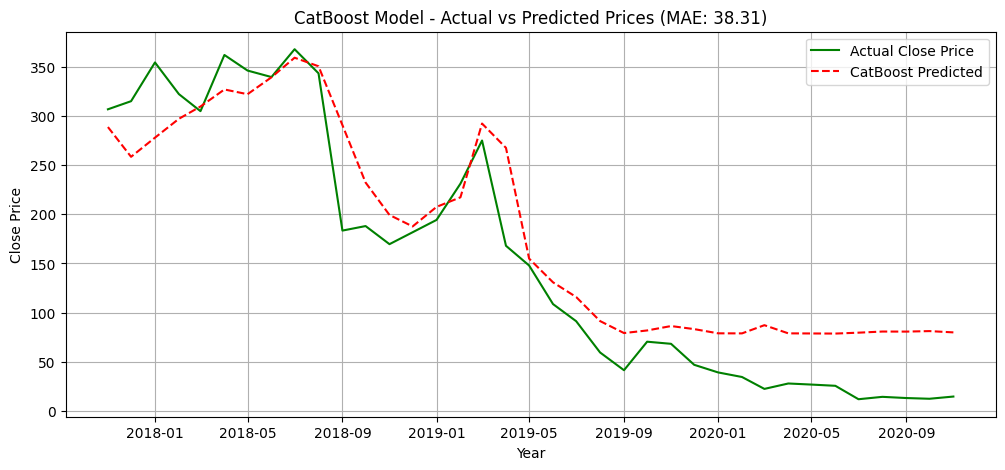

In [47]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(bank_data['Date'].iloc[len(X_train):], y_test, label="Actual Close Price", color='green')
plt.plot(bank_data['Date'].iloc[len(X_train):], cat_predictions, label="CatBoost Predicted", color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.title(f"CatBoost Model - Actual vs Predicted Prices (MAE: {cat_mae:.2f})")
plt.legend()
plt.grid(True)
plt.show()

**Observation:** The insights reveal that while the CatBoost model follows the general trend of stock prices, it exhibits noticeable deviations, particularly during sharp declines. With an MAE of 38.31, its predictions are less accurate than other models.

In [48]:
mae = 38.31  # MAE value
mae_percentage = (mae / average_price) * 100
print(f"MAE Percentage: {mae_percentage:.2f}%")

MAE Percentage: 36.41%


In [49]:
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 40)

# Example usage for each model
evaluate_model(y_test, predictions, "ARIMA")
evaluate_model(y_test, xgb_predictions, "XGBoost")
evaluate_model(y_test, rf_predictions, "RandomForest")
evaluate_model(y_test, cat_predictions, "CatBoost")

ARIMA Performance:
MAE: 144.3484
MSE: 29051.9011
RMSE: 170.4462
R² Score: -0.7694
----------------------------------------
XGBoost Performance:
MAE: 14.1824
MSE: 681.9181
RMSE: 26.1136
R² Score: 0.9585
----------------------------------------
RandomForest Performance:
MAE: 13.9085
MSE: 482.8485
RMSE: 21.9738
R² Score: 0.9706
----------------------------------------
CatBoost Performance:
MAE: 38.3061
MSE: 2181.6847
RMSE: 46.7085
R² Score: 0.8671
----------------------------------------


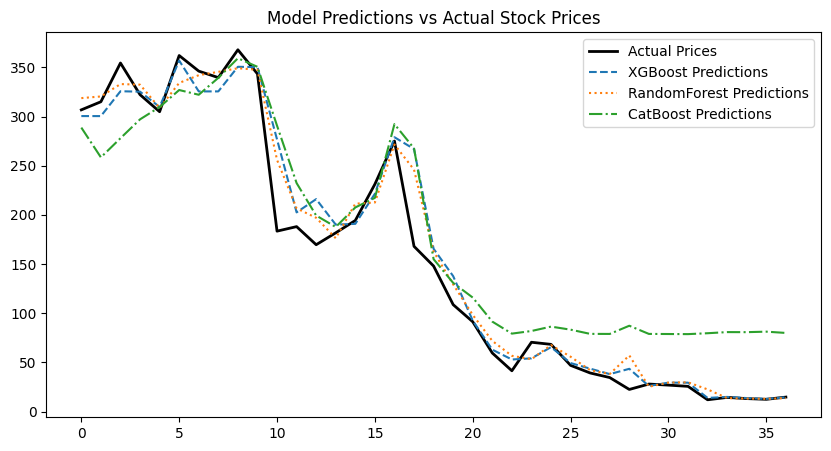

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Prices", color="black", linewidth=2)
plt.plot(xgb_predictions, label="XGBoost Predictions", linestyle="dashed")
plt.plot(rf_predictions, label="RandomForest Predictions", linestyle="dotted")
plt.plot(cat_predictions, label="CatBoost Predictions", linestyle="dashdot")
plt.legend()
plt.title("Model Predictions vs Actual Stock Prices")
plt.show()

**Observation:**
- **XGBoost and RandomForest** closely track the actual prices, especially in the high-value range, showing their reliability.
- **CatBoost** deviates more, particularly after the large drop in prices, indicating it struggles with sharp trend changes.
- **XGBoost and RandomForest** seem to have the best alignment with actual values, suggesting they are the more effective models for this dataset.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

By analyzing the different models (ARIMA, XGBoost, Random Forest, and CatBoost) for Yes Bank stock price predictions, we can draw the following **conclusions**:
- **Stock Trend Analysis:**
    - The actual stock price showed a significant decline after 2018, primarily due to fraud allegation and dropping from Rs.350 to below Rs.50 by 2020.
- **Model Performance Evaluation:**
    - **XGBoost Model** (MAE: 14.18) performed the best among all models, closely following actual price movements.
    - **Random Forest** (MAE: 14.63) also performed well, with slightly higher error but still reliable predictions.
    - **CatBoost** (MAE: 38.31) struggled to predict the stock’s downward trend, showing over-optimistic predictions in later periods.
    - **ARIMA** (MAE: 144.35) was the least effective, likely due to its limitations in handling sudden stock price crashes and complex patterns.

Yes Bank stock exhibited high volatility and a long-term downtrend, making it a risky investment. While ML models can provide short-term forecasts, fundamental analysis is crucial to understand whether the stock has recovery potential.